In [1]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
import aplpy
from astropy import wcs
from astropy.nddata import Cutout2D

import numpy as np
import matplotlib.pyplot as plt

from photutils.detection import IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

In [2]:

# Parameters
coords = "18 25 22.020 -00 00 43.00"
radius = 0.6
literature = "Liu+2007, X-ray"
known_counterpart = 'n' # default n since its the savest to do it for all sources
source = "4U_1822-00"
obs = "1175"
band = 'H'
FSRED_dir = "E:/Scriptie/"
file_name = "2018-06-19_H_4U_1822-00_1175_c1-4_58288_30295.mos.fits.cat"
nH = 3.36*10**(21)
nH_err = 0*10**(22) # used for calculating the error on the extinction but I dont known nH_err 
#%matplotlib notebook


# Importing catalog and image data, creating a coordinate object for the XRB position,
# and defining figure names
XRB_coo = SkyCoord(coords, unit=(u.hourangle,u.deg))
flname = FSRED_dir + "FSRED/u018918_data/" + source + "/" + file_name # SExtractor catalog from the Taurus computer
data = fits.getdata(flname,2)

# Checking the data columns that are in the catalogs
print(data.columns)

ColDefs(
    name = 'X_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'Y_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'FLUX_RADIUS'; format = '1E'; unit = 'pixel'; disp = 'F10.3'
    name = 'FLUX_AUTO'; format = '1E'; unit = 'count'; disp = 'G12.7'
    name = 'FLUXERR_AUTO'; format = '1E'; unit = 'count'; disp = 'G12.7'
    name = 'FLUX_MAX'; format = '1E'; unit = 'count'; disp = 'G12.7'
    name = 'ELONGATION'; format = '1E'; disp = 'F8.3'
    name = 'MAG_AUTO'; format = '1E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAGERR_AUTO'; format = '1E'; unit = 'mag'; disp = 'F8.4'
    name = 'FWHM_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F8.2'
    name = 'CLASS_STAR'; format = '1E'; disp = 'F6.3'
    name = 'FLAGS'; format = '1I'; disp = 'I3'
    name = 'VIGNET'; format = '625E'; unit = 'count'; disp = 'G12.7'; dim = '(25, 25)'
    name = 'SNR_WIN'; format = '1E'; disp = 'G10.4'
)


In [3]:
# from astropy.stats import sigma_clipped_stats
# from photutils.detection import find_peaks

# hdulist = fits.open(flname.split(".fits")[0] + "_astrocal.fits") 
# fitsdata = hdulist[0].data
# hdulist.close()

# mean, median, std = sigma_clipped_stats(fitsdata, sigma=3.0)
# print((mean, median, std))  
# threshold = median + (2. * std)
# tbl = find_peaks(fitsdata, threshold, box_size=11)
# tbl['peak_value'].info.format = '%.8g'  # for consistent table output
# print(tbl[:10])  # print only the first 10 peaks

In [4]:

# from astropy.visualization import simple_norm
# from astropy.visualization.mpl_normalize import ImageNormalize
# from photutils.aperture import CircularAperture

# positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
# apertures = CircularAperture(positions, r=5.)
# norm = simple_norm(fitsdata, 'sqrt', percent=99.9)
# plt.imshow(fitsdata, cmap='Greys_r', origin='lower', norm=norm,
#            interpolation='nearest')
# apertures.plot(color='#0547f9', lw=1.5)
# plt.xlim(0, fitsdata.shape[1] - 1)
# plt.ylim(0, fitsdata.shape[0] - 1)
# plt.show()

In [5]:
# hdulist = fits.open(flname.split(".fits")[0] + "_astrocal.fits")  # open the mos.fits file 
# w = wcs.WCS(hdulist[0].header)
# hdulist.close()

# ra, dec = w.wcs_pix2world(tbl['x_peak'], tbl['y_peak'], 0, ra_dec_order=True)

# # Visualize pixels to sample
# gc = aplpy.FITSFigure(flname.split(".fits")[0] + "_astrocal.fits")
# gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1, vmax=200)
# gc.show_markers(ra, dec, 
#                 edgecolor='b', facecolor='b',
#                 marker='.', s=80, alpha=1,label="2MASs")

# # XRB source
# gc.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600.,
#                 edgecolor='g', facecolor='none', alpha=1)
# # Recentering on XRB source
# gc.recenter(XRB_coo.ra.deg, XRB_coo.dec.deg, 
#             radius=5/3600.)# degrees
# gc.add_colorbar()

# PSF

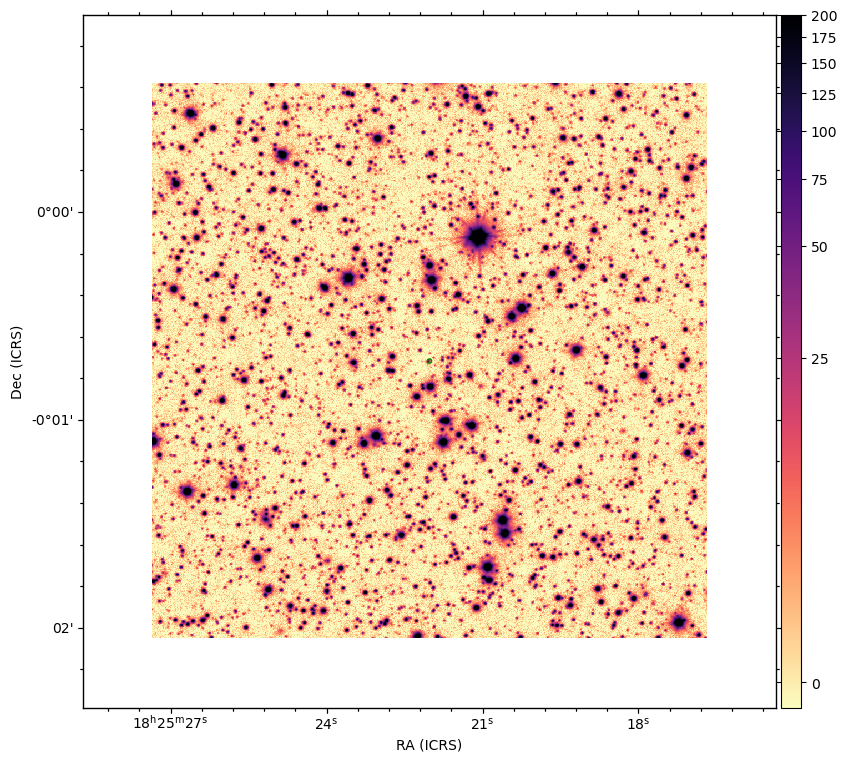

In [6]:
""" 
Create cutout around source for selecting stars for model. 
""" 


# Load the image and the WCS
hdulist_cut = fits.open(flname.split(".fits")[0] + "_astrocal.fits")[0]  # open the calibrated mos.fits file 
w = wcs.WCS(hdulist_cut.header)

# Make the cutout, including the WCS
size = (1000,1000)
cutout = Cutout2D(hdulist_cut.data, position=XRB_coo, size=size, wcs=w)

# Put the cutout image in the FITS HDU
hdulist_cut.data = cutout.data

# Update the FITS header with the cutout WCS
hdulist_cut.header.update(cutout.wcs.to_header())


gc = aplpy.FITSFigure(hdulist_cut)
gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1, vmax=200)

# XRB source
gc.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600.,
                edgecolor='g', facecolor='none', alpha=1)
# Recentering on XRB source
gc.recenter(XRB_coo.ra.deg, XRB_coo.dec.deg, 
            radius=100/3600.)# degrees
gc.add_colorbar()


# Try to build effective point spread function

x_peak y_peak peak_value
------ ------ ----------
   912      0  927.23187
   664      1  979.06879
   478      2   8286.458
   514      2  787.65216
   985      5   796.7774
   351     14  446.34848
   267     18  339.88934
   169     19  670.61047
   832     22  417.96643
   729     23  814.62659
   ...    ...        ...
   587    957  2487.2781
   532    961  721.22217
   565    976   2662.752
   360    979  539.01459
   841    980  2687.7615
   353    981  912.48676
   606    981  1140.8652
   794    984  738.76624
   388    996  885.74084
   215    997  713.61115
   727    999  838.42261
Length = 347 rows


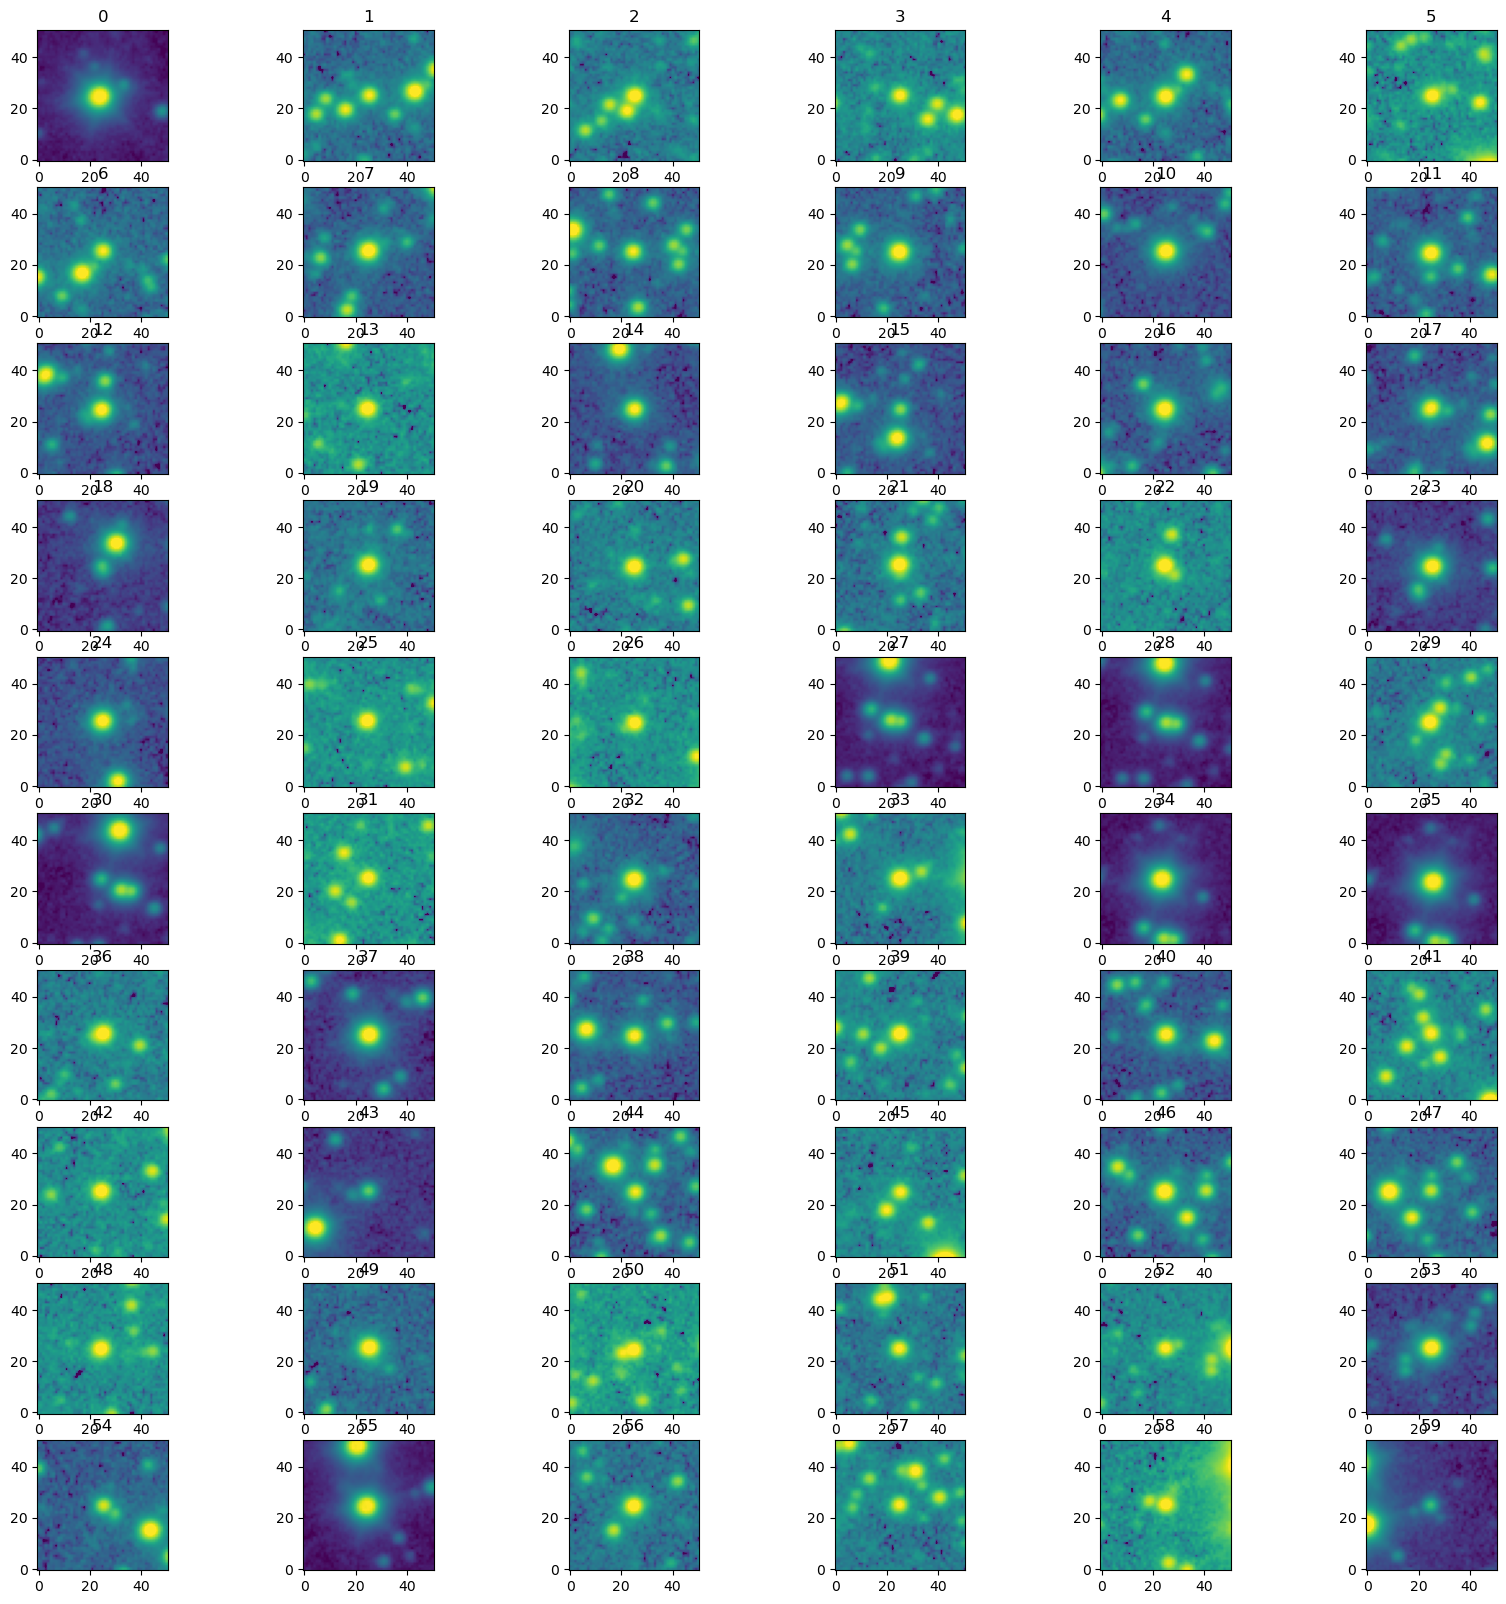

In [7]:
from astropy.nddata import NDData
from photutils.detection import find_peaks
from astropy.table import Table
from photutils.psf import extract_stars
from astropy.visualization import simple_norm
from photutils.psf import EPSFBuilder

threshold = 300

data = hdulist_cut.data
nddata = NDData(data=data)  
peaks_tbl = find_peaks(data, threshold=threshold)  
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)  

size = 51
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))  

stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask]  

stars = extract_stars(nddata, stars_tbl, size=size)  

nrows = 10
ncols = 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
    ax[i].set_title(i)

[ 214.1629    193.57716   287.35257   571.8356    888.3192   1014.25555
  866.7277    725.3332    746.25684   667.98065   417.59213   240.663
  237.39008   408.80554   793.79956  1433.8912   1867.8661   1577.7476
  963.5214    475.00848   284.6382    282.5301    463.92715   789.51904
 1403.4104   2043.6665   1957.5988   1185.5857    531.9245    226.64967
  171.0174    113.949554  108.77775   163.0409    307.17395   440.34714
  444.5       315.02646   288.81497   463.99533   995.2174   2038.4026
 3707.7405   5004.0723   4301.4033   2437.5151   1172.7775    747.3458
  787.9281   1090.9996   1617.6375  ]


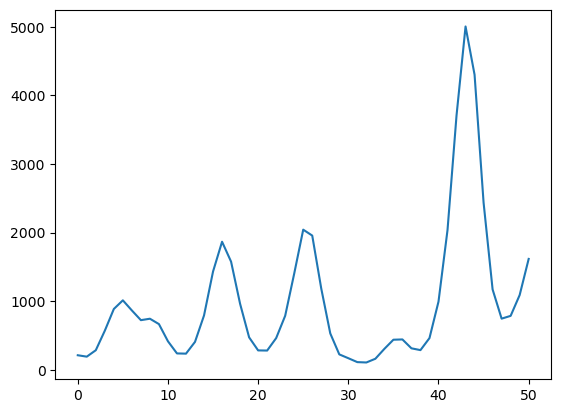

In [8]:
ff = stars[1]
print(np.sum(ff, axis=0))
plt.plot(np.sum(ff, axis=0))



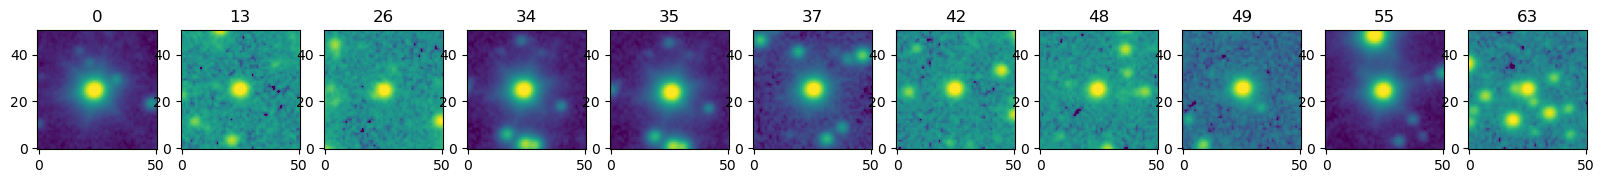

In [9]:
""" 
Select images
""" 

good_images = [0, 13, 26, 34, 35, 37, 42, 48, 49, 55, 63]
size=51
good_table = stars_tbl[good_images]
good_stars = extract_stars(nddata, good_table, size=size)  

nrows = 1
ncols = len(good_images)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(good_stars[i], 'log', percent=99.)
    ax[i].imshow(good_stars[i], norm=norm, origin='lower', cmap='viridis')
    ax[i].set_title(good_images[i])

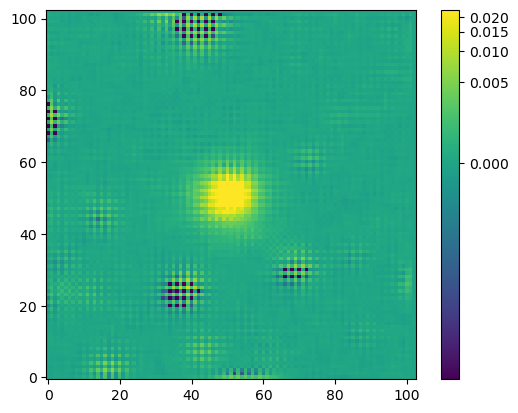

In [10]:
""" 
Build epsf
""" 

epsf_builder = EPSFBuilder(oversampling=1, maxiters=3,
                           progress_bar=False)  
epsf, fitted_stars = epsf_builder(good_stars)  

norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

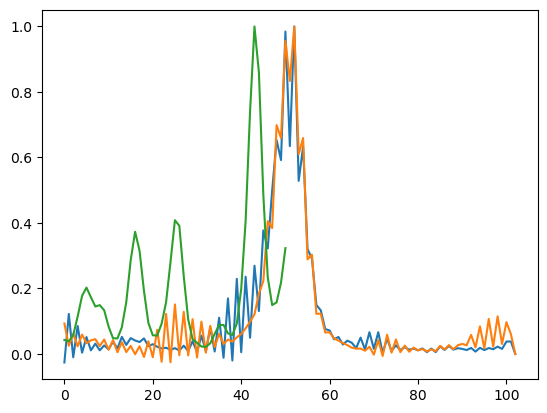

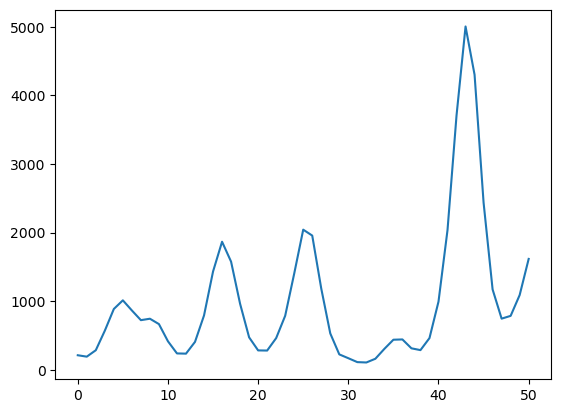

In [11]:
plt.plot(np.sum(epsf.data, axis=0)/max(np.sum(epsf.data, axis=0)))
plt.plot(np.sum(epsf.data, axis=1)/max(np.sum(epsf.data, axis=1)))
ff = stars[1]
plt.plot((np.sum(ff, axis=0))/max(np.sum(ff, axis=0)))
plt.show()

plt.plot((np.sum(ff, axis=0)))

# calculate residuals for target star: calculate how much flux you lose

# try psf 

In [12]:
""" 
Create even smaller cutout around source to apply psf on. 
""" 


# Load the image and the WCS
hdulist_cut = fits.open(flname.split(".fits")[0] + "_astrocal.fits")[0]  # open the calibrated mos.fits file 
w = wcs.WCS(hdulist_cut.header)

# Make the cutout, including the WCS
size = (200,200)
cutout = Cutout2D(hdulist_cut.data, position=XRB_coo, size=size, wcs=w)

# Put the cutout image in the FITS HDU
hdulist_cut.data = cutout.data

# Update the FITS header with the cutout WCS
hdulist_cut.header.update(cutout.wcs.to_header())

In [13]:
""" 
Do PSF photometry.
""" 

sigma_psf = 2.
image = hdulist_cut.data

bkgrms = MADStdBackgroundRMS()
std = bkgrms(image)
iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf * gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)
daogroup = DAOGroup(2.0 * sigma_psf * gaussian_sigma_to_fwhm)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()
psf_model = epsf #IntegratedGaussianPRF(sigma=sigma_psf)

from photutils.psf import IterativelySubtractedPSFPhotometry
photometry = IterativelySubtractedPSFPhotometry(finder=iraffind,
                                                group_maker=daogroup,
                                                bkg_estimator=mmm_bkg,
                                                psf_model=psf_model,
                                                fitter=LevMarLSQFitter(),
                                                niters=1, fitshape=(11, 11))
result_tab = photometry(image=image)
residual_image = photometry.get_residual_image()

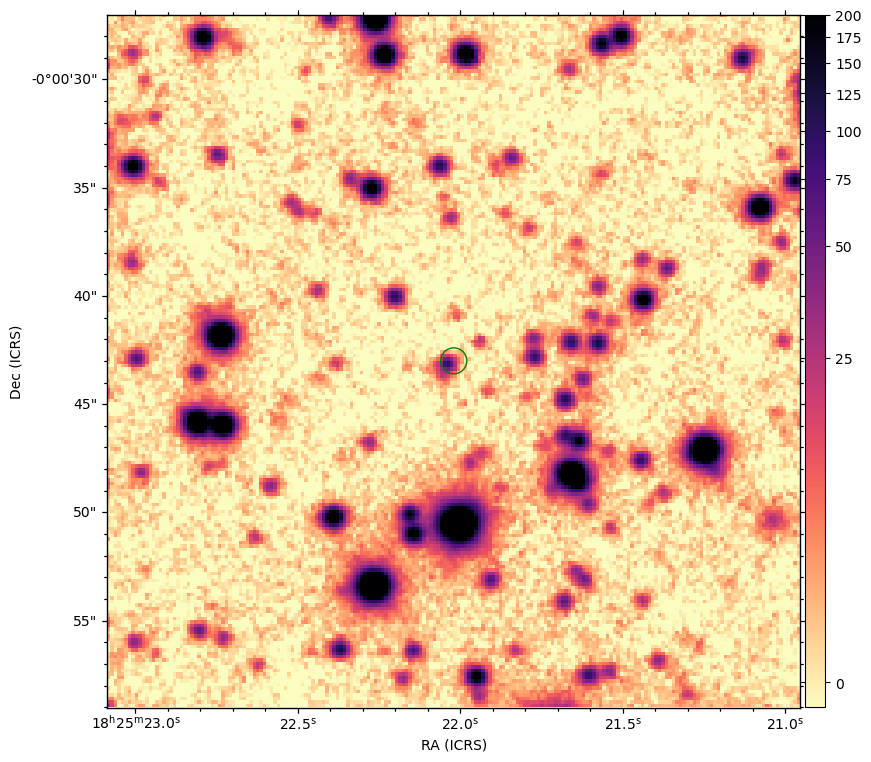

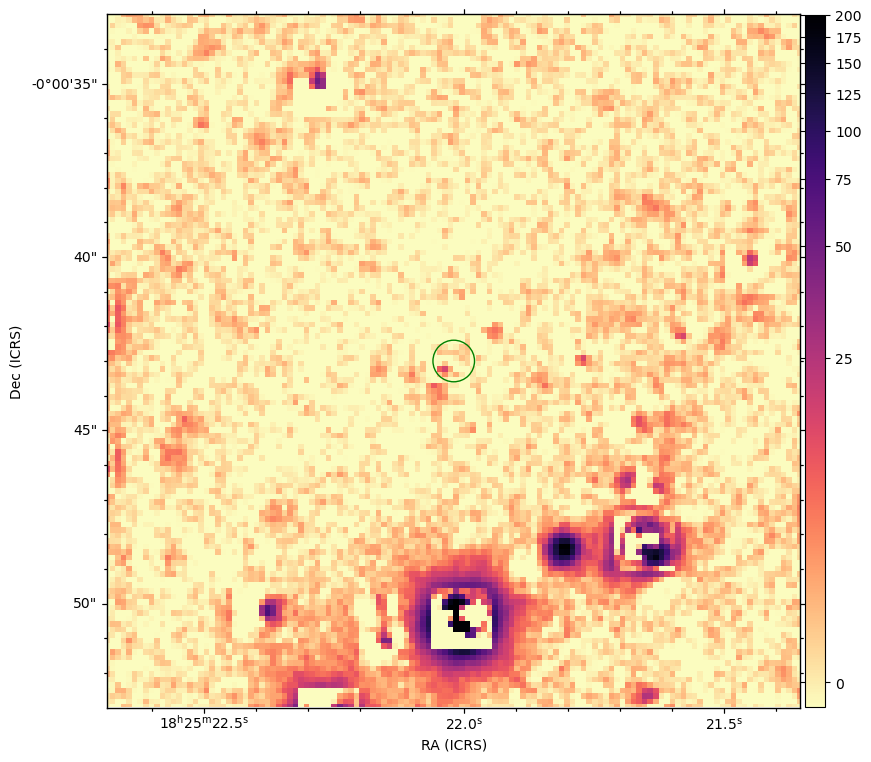

In [14]:
""" 
Plot data and residuals. 
""" 

hdulist_cut.data = image
hdulist_cut.header.update(cutout.wcs.to_header())
gc = aplpy.FITSFigure(hdulist_cut)
gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1, vmax=200)

# XRB source
gc.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600.,
                edgecolor='g', facecolor='none', alpha=1)
gc.add_colorbar()


hdulist_res = hdulist_cut
hdulist_res.data = residual_image
hdulist_res.header.update(cutout.wcs.to_header())
gc = aplpy.FITSFigure(hdulist_res)
gc.show_colorscale(cmap='magma_r',stretch='arcsinh',vmin=-1, vmax=200)

# XRB source
gc.show_circles(XRB_coo.ra.deg, XRB_coo.dec.deg, radius/3600.,
                edgecolor='g', facecolor='none', alpha=1)
gc.recenter(XRB_coo.ra.deg, XRB_coo.dec.deg, radius=10/3600)
gc.add_colorbar()

In [18]:
display(result_tab)

# TODO retrieve flux_fit and flux_unc from table as flux estimate and uncertainty
# TODO convert to magnitude with zeropoint (TODO denk error dan +/- doen en dat naar magnitude doen)

x_0,x_fit,y_0,y_fit,flux_0,flux_fit,id,group_id,flux_unc,x_0_unc,y_0_unc,iter_detected
float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,int32
0.8449771022293713,-0.12902356400080384,0.7897485678866003,0.018514272845547113,113.97642172957612,543.8836819847629,1,1,39.695837409607,0.06473970066261099,0.08323741686592834,1
121.22957161109022,120.87342456306749,0.7834840559992173,0.4135130803210041,481.0891006127454,321.81029909665114,2,2,71.36986815649178,0.07994867133636001,0.12334674339149679,1
124.16384995926661,124.21233889224746,0.7215582268105774,0.12455946382822784,596.3334790824001,337.63040339262733,3,2,83.69127669711764,0.012822218419938565,0.012936819862024334,1
129.04188347076783,128.96143472625698,1.0308020510502587,1.3659070103605497,737.9793077377722,452.1650534648305,4,2,33.12601643526497,0.0410714764051958,0.09476655013342863,1
132.53809006137297,133.09563623489902,0.9338353975889695,0.3389190207536712,674.3975351028164,529.9749358120933,5,2,81.41628448264954,0.026904091021235355,0.03217295470736845,1
106.89005076465806,107.00063390835466,2.9807806022030725,2.8886344189085706,1910.2580578089428,629.3917615570367,6,3,62.13812623666999,0.03899321131946798,0.06628999819614911,1
106.18750444376157,106.26108306197786,8.215111732248578,8.220429164781024,3915.9370134584415,4081.9991756222316,9,3,29.61711778582537,0.03942006904215555,0.06342198826227545,1
167.05319560417297,167.08188857459558,3.1536221366172037,3.3910284725633386,458.59561930561057,423.01908255686607,7,4,34.78364540900479,0.0333795099998627,0.03821780349229321,1
84.957220158235,85.0088868246621,7.816120806173036,8.012613971275709,606.3769649682602,823.4380983408176,8,5,58.756508569521735,0.07179713193330474,0.09559477941382626,1


x_peak y_peak peak_value
------ ------ ----------
    78     34  314.71417
   101     52  1184.2252
   100     55  362.43335


IndexError: list index out of range

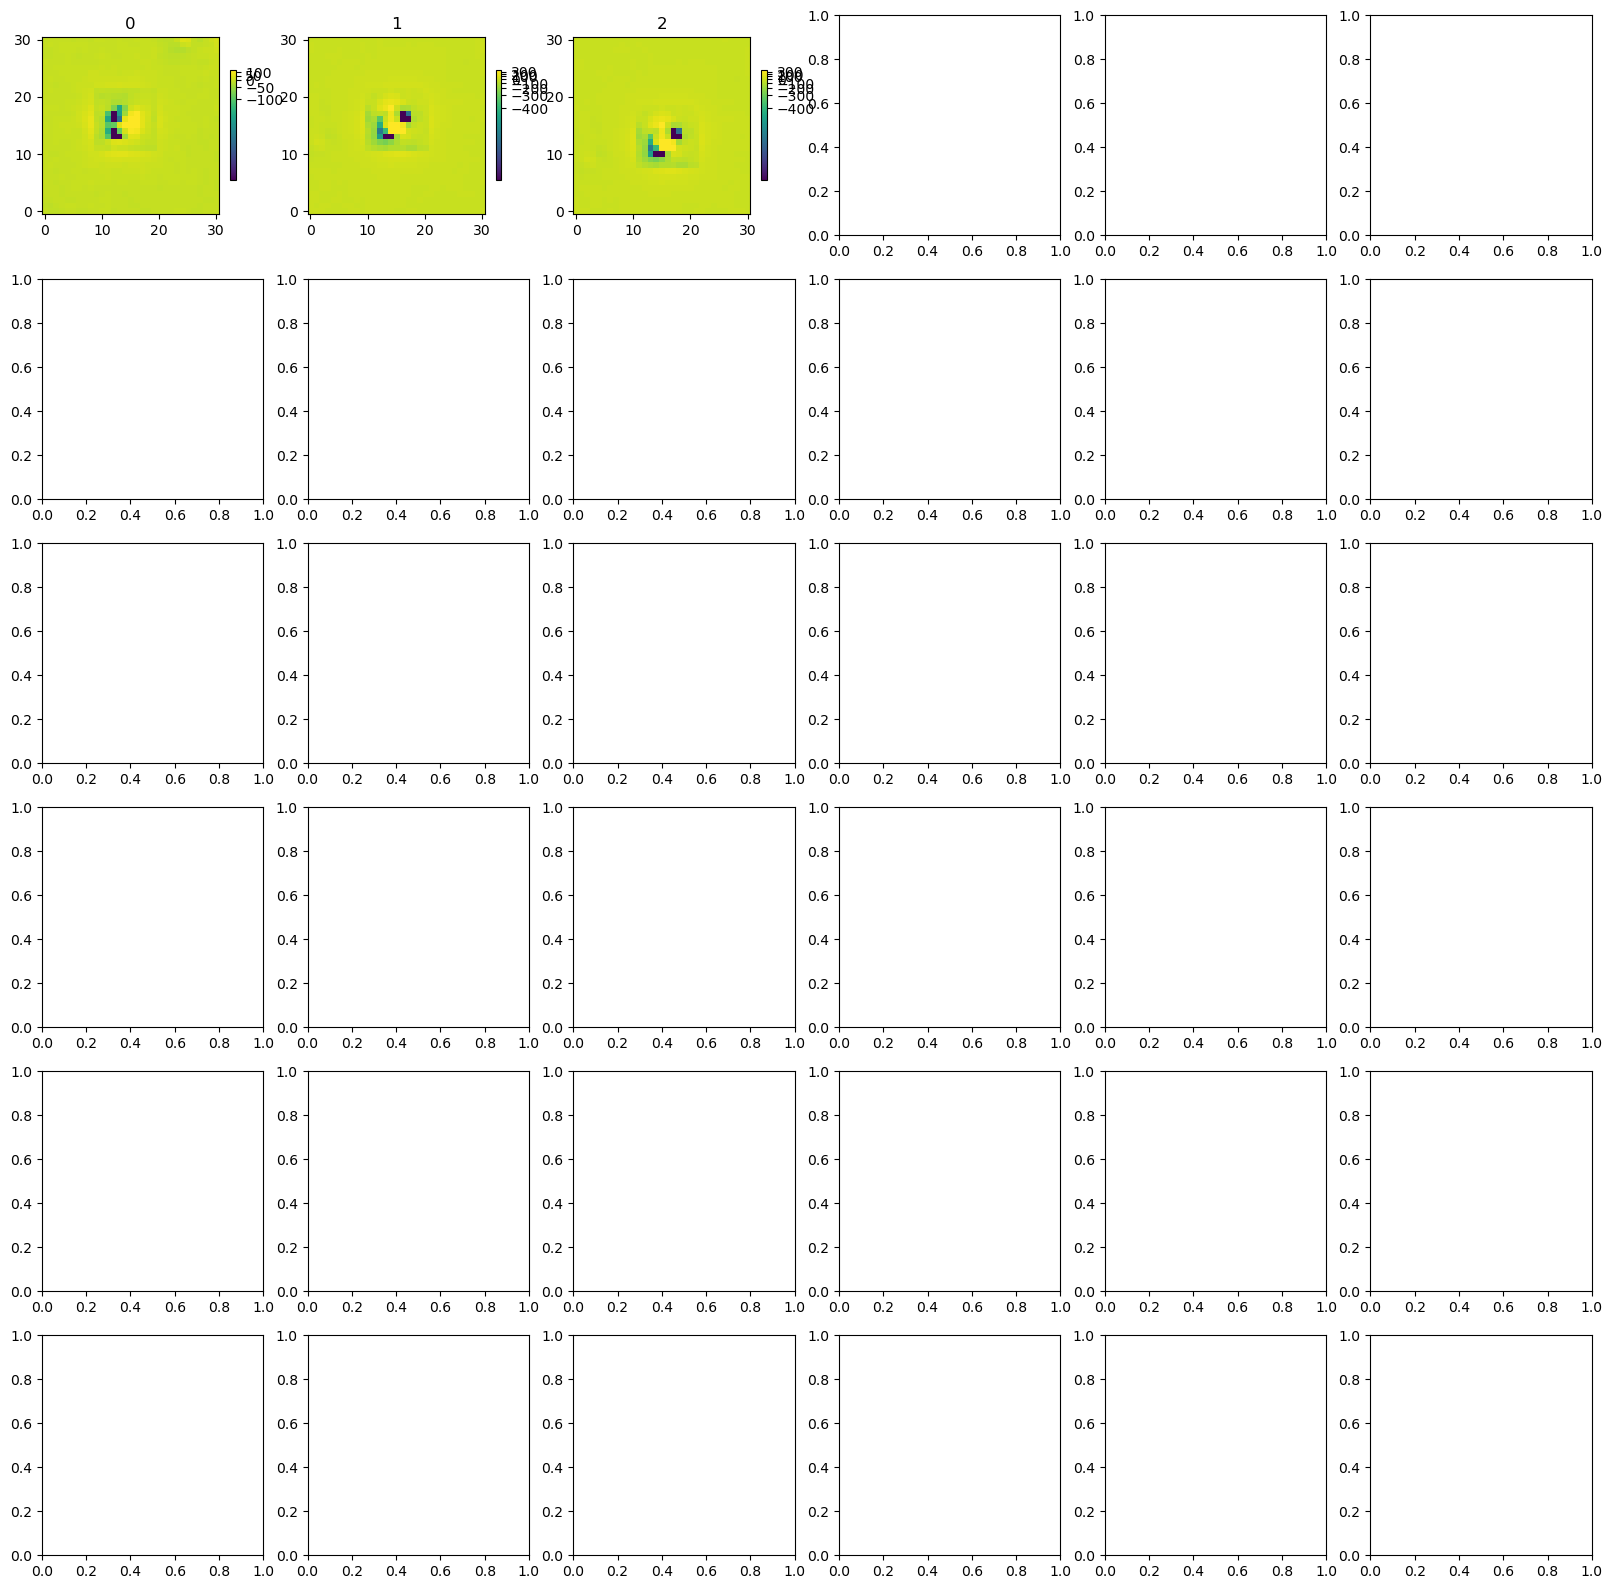

In [16]:
data_res = hdulist_res.data
nddata_res = NDData(data=data_res)  



peaks_tbl = find_peaks(data_res, threshold=threshold)  
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)  

size = 31
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (data_res.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data_res.shape[0] -1 - hsize)))  

stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask]  



size = 31
stars = extract_stars(nddata_res, stars_tbl, size=size)  

nrows = 6
ncols = 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    im = ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
    ax[i].set_title(i)
    fig.colorbar(im, ax=ax[i], shrink=0.5)

In [ ]:
ff = stars[1]
plt.plot(np.sum(ff, axis=0)/size)
plt.plot(np.sum(ff, axis=1)/size)
plt.show()

ff = stars[9]
plt.plot(np.sum(ff, axis=0)/size)
plt.plot(np.sum(ff, axis=1)/size)
plt.show()
